In [1]:
from torchdyn.core import NeuralODE
from torchdyn.models import CNF, hutch_trace, autograd_trace
from torchdyn.nn import DataControl, DepthCat, Augmenter
from torchdyn.datasets import *
from torchdyn.utils import *

In [2]:
# quick run for automated notebook validation
dry_run = False

torch.Size([20000, 30, 2])


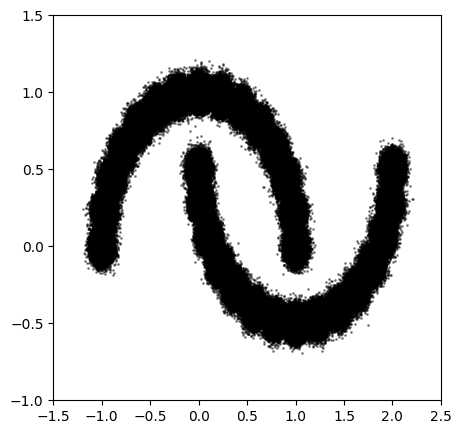

In [27]:
from sklearn.datasets import make_moons
X = []
yn = []
num_points = 30
len_data = 20000
for _ in range(len_data):
    x,y = make_moons(n_samples=num_points,noise=0.05,shuffle=True)
    X.append(x)
    yn.append(y)
X = torch.tensor(np.array(X),dtype=torch.float32)
yn = torch.tensor(np.array(yn),dtype=torch.float32)

X = X.squeeze()
yn = yn.squeeze()
print(X.shape)


import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.scatter(X[...,0], X[...,1], c='black', alpha=0.4, s=1.)
plt.xlim(-1.5, 2.5) ; plt.ylim(-1, 1.5)
plt.show()

In [28]:
import torch
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
X_train = torch.Tensor(X).to(device)
y_train = torch.Tensor(yn).to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=1024, shuffle=True) 

In [29]:
device

device(type='cuda', index=0)

In [30]:
f = nn.Sequential(
        nn.Linear(2, 64),
        nn.Softplus(),
        nn.Linear(64, 64),
        nn.Softplus(),
        nn.Linear(64, 64),
        nn.Softplus(),
        nn.Linear(64, 2),
    )
# cnf wraps the net as with other energy models
# default trace_estimator, when not specified, is autograd_trac
import sys 
import os
sys.path.append(os.path.abspath("/home/ewencedr/deep-learning/src/models"))
from components import SelfAttention
f = SelfAttention(2,[64,64],2)

In [31]:
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform, Categorical


In [34]:
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, net:nn.Module):
        super().__init__()
        self.net = net
        self.iters = 0
        self.cnf = CNF(self.net, trace_estimator=autograd_trace)
        self.nde = NeuralODE(self.cnf, solver='dopri5', sensitivity='adjoint', atol=1e-4, rtol=1e-4)
        self.model = nn.Sequential(Augmenter(augment_idx=1, augment_dims=1),self.nde)
        self.prior = MultivariateNormal(torch.zeros(2), torch.eye(2))
        
    def forward(self, x):
        return self.model(x)
    
    def sample(self, num_samples):
        sample = self.prior.sample(torch.Size([num_samples]))
        # integrating from 1 to 0
        self.model[1].t_span = torch.linspace(1, 0, 2)
        new_x = self.model(sample)[1]
        return new_x
        
    def training_step(self, batch, batch_idx):
        self.iters += 1
        x, _ = batch 
        t, xtrJ = self.model(x)
        print(f"t: {t}")
        print(f"xtrJ.shape: {xtrJ.shape}")
        logprob = self.prior.log_prob(xtrJ[1, ...,1:]) - xtrJ[1, ...,0] # logp(z_S) = logp(z_0) - \int_0^S trJ
        loss = -torch.mean(logprob)
        self.nde.nfe = 0
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=2e-3, weight_decay=1e-5)

    def train_dataloader(self):
        return trainloader

In [ ]:
#t: tensor([0., 1.], grad_fn=<_ODEProblemFuncBackward>)
#xtrJ.shape: torch.Size([2, 1024, 3])

#t: tensor([0., 1.], grad_fn=<_ODEProblemFuncBackward>)
#xtrJ.shape: torch.Size([2, 1024, 31, 2])

In [35]:
learn = Learner(f)
trainer = pl.Trainer(max_epochs=10)
trainer.fit(learn)

/beegfs/desy/user/ewencedr/conda/envs/pllhydra/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ewencedr/.local/lib/python3.9/site-packages/ip ...
  rank_zero_warn(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/beegfs/desy/user/ewencedr/conda/envs/pllhydra/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name  | Type          | Params
----------------------------------------
0 | net   | SelfAttention | 13.2 K
1 | cnf   | CNF           | 13.2 K
2 | nde   | NeuralODE     | 13.2 K
3 

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/beegfs/desy/user/ewencedr/conda/envs/pllhydra/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/beegfs/desy/user/ewencedr/conda/envs/pllhydra/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

t: tensor([0., 1.], grad_fn=<_ODEProblemFuncBackward>)
xtrJ.shape: torch.Size([2, 1024, 31, 2])


ValueError: The right-most size of value must match event_shape: torch.Size([1024, 31, 1]) vs torch.Size([2]).

In [20]:
new_x = learn.sample(7000).cpu().detach()[1]
#new_x = learn.sample(10)

Text(0.5, 1.0, 'Data')

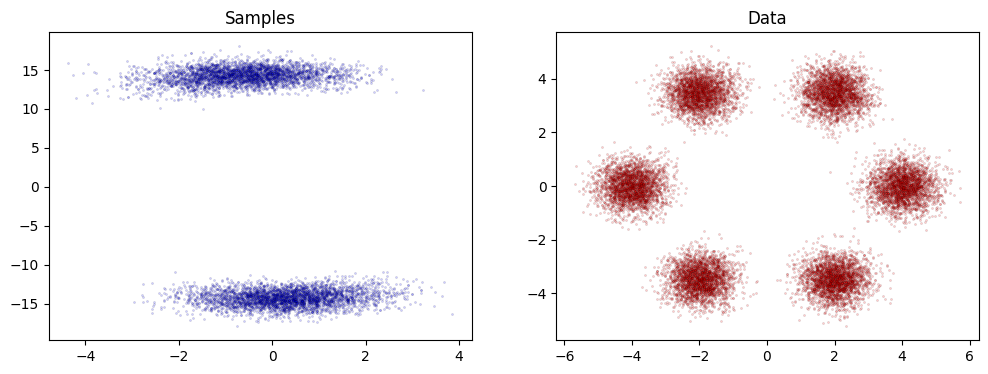

In [21]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(new_x[:,1], new_x[:,2], s=2.3, alpha=0.2, linewidths=0.3, c='blue', edgecolors='black')
#plt.xlim(-6, 6) ; plt.ylim(-6, 6)
plt.title('Samples')

plt.subplot(122)
plt.scatter(X[:,0], X[:,1], s=2.3, alpha=0.2, c='red',  linewidths=0.3, edgecolors='black')
#plt.xlim(-6, 6) ; plt.ylim(-6, 6)
plt.title('Data')

In [ ]:
traj = model[1].trajectory(Augmenter(1, 1)(sample.to(device)), t_span=torch.linspace(1, 0, 100)).detach().cpu()
sample = sample.cpu()
traj = traj[:, :, 1:] # scrapping first dimension := jacobian trace

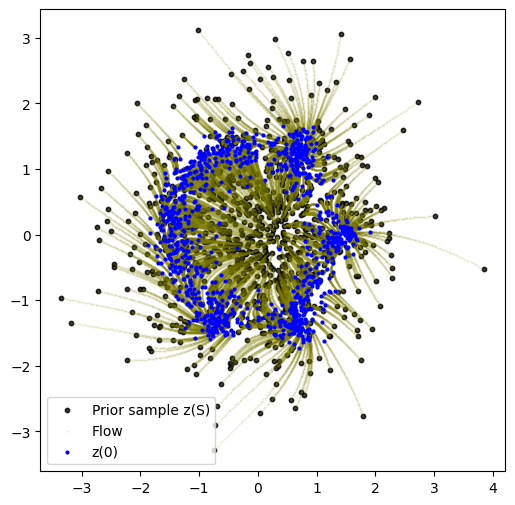

In [ ]:
n = 2000
plt.figure(figsize=(6,6))
plt.scatter(sample[:n,0], sample[:n,1], s=10, alpha=0.8, c='black')
plt.scatter(traj[:,:n,0], traj[:,:n,1], s=0.2, alpha=0.2, c='olive')
plt.scatter(traj[-1,:n,0], traj[-1,:n,1], s=4, alpha=1, c='blue')
plt.legend(['Prior sample z(S)', 'Flow', 'z(0)'])